# Laboratorium 6 - rekomendacje grafowe

## Przygotowanie

 * pobierz i wypakuj dataset `movies_graph.zip`:
   * dane źródłowe: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data
   * więcej o przekształceniach i filtrowaniu możesz poczytać w notebooku `movies_graph_data_preparation.ipynb`
 * [opcjonalnie] utwórz wirtualne środowisko:
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install pykeen torch tqdm seaborn`

## Część 1. - przygotowanie danych

In [1]:
import csv
import numpy as np

from typing import List, Dict, Tuple
from random import shuffle
from ast import literal_eval
from codecs import open
from pykeen.models import ERModel, TransE, TransH, TransR
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

c:\Users\micha\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# używane stałe
PATH = 'movies_graph'
TRAIN_DATA_RATIO = 0.9

In [3]:
# dataclasses
class Movie:
    def __init__(
        self,
        movie_id: str,
        title: str,
        genres: List[str], 
        production_countries: List[str], 
        collection_name: str,
        release_year: str
    ):
        self.movie_id = movie_id
        self.title = title
        self.genres = genres
        self.production_countries = production_countries
        self.collection_name = collection_name
        self.release_year = release_year
    
    
    def add_cast(
        self,
        actors: List[str],
        directors: List[str],
        screenwriters: List[str],
        music_composers: List[str]
    ):
        self.actors = actors
        self.directors = directors
        self.screenwriters = screenwriters
        self.music_composers = music_composers
    

    def basic_info(self):
        return {
            'movie_id': self.movie_id,
            'title': self.title,
            'genres': self.genres,
            'production_countries': self.production_countries
        }


    def __str__(self):
        return str(vars(self))
    

    def __repr__(self):
        return self.__str__()


class Review:
    def __init__(self, user_id: str, movie_id: str, rating: str):
        self.user_id = user_id
        self.movie_id = movie_id
        self.rating = float(rating)
    

    def __str__(self):
        return str(vars(self))
    
    
    def __repr__(self):
        return self.__str__()

In [4]:
# wczytujemy oceny filmów
with open(f'{PATH}/reviews.csv', encoding='UTF-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    ratings = []

    for entry in list(reader):
        user_id, movie_id, rating = entry
        ratings.append(Review(f'u_{user_id}', f'm_{movie_id}', rating))

# podział na zbiór treningowy i testowy
shuffle(ratings)
train_ratings = ratings[:int(len(ratings) * TRAIN_DATA_RATIO)]
test_ratings = ratings[len(train_ratings):]
train_ratings

[{'user_id': 'u_392', 'movie_id': 'm_605', 'rating': 4.0},
 {'user_id': 'u_307', 'movie_id': 'm_48780', 'rating': 4.0},
 {'user_id': 'u_384', 'movie_id': 'm_2054', 'rating': 2.0},
 {'user_id': 'u_119', 'movie_id': 'm_223', 'rating': 4.0},
 {'user_id': 'u_299', 'movie_id': 'm_5673', 'rating': 3.0},
 {'user_id': 'u_595', 'movie_id': 'm_594', 'rating': 3.0},
 {'user_id': 'u_481', 'movie_id': 'm_2065', 'rating': 4.0},
 {'user_id': 'u_659', 'movie_id': 'm_306', 'rating': 4.0},
 {'user_id': 'u_238', 'movie_id': 'm_2424', 'rating': 3.0},
 {'user_id': 'u_23', 'movie_id': 'm_595', 'rating': 4.0},
 {'user_id': 'u_232', 'movie_id': 'm_3201', 'rating': 3.0},
 {'user_id': 'u_222', 'movie_id': 'm_3408', 'rating': 3.0},
 {'user_id': 'u_212', 'movie_id': 'm_2599', 'rating': 3.0},
 {'user_id': 'u_328', 'movie_id': 'm_1283', 'rating': 3.0},
 {'user_id': 'u_355', 'movie_id': 'm_2944', 'rating': 3.0},
 {'user_id': 'u_128', 'movie_id': 'm_4054', 'rating': 5.0},
 {'user_id': 'u_382', 'movie_id': 'm_4995', '

In [5]:
# wczytujemy metadane filmów
def parse_movie_metadata(entry: List[str]):
    movie_id, title, genres, production_countries, collection_name, release_year = entry

    return Movie(
        f'm_{movie_id}',
        title,
        literal_eval(genres),
        literal_eval(production_countries),
        collection_name,
        release_year
    )


def add_cast_to_movie(movie: Movie, entry: List[str]):
    _movie_id, actors, directors, screenwriters, music_composers = entry
    movie.add_cast(
        literal_eval(actors),
        literal_eval(directors),
        literal_eval(screenwriters),
        literal_eval(music_composers)
    )


with open(f'{PATH}/metadata.csv', encoding='UTF-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    movies = {f'm_{entry[0]}': parse_movie_metadata(entry) for entry in reader}

with open(f'{PATH}/credits.csv', encoding='UTF-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    
    for entry in reader:
        movie_id = f'm_{entry[0]}'
        add_cast_to_movie(movies[movie_id], entry)

movies

{'m_949': {'movie_id': 'm_949', 'title': 'Heat', 'genres': ['Action', 'Crime', 'Drama', 'Thriller'], 'production_countries': ['US'], 'collection_name': '', 'release_year': '1995', 'actors': ['Al Pacino', 'Robert De Niro', 'Val Kilmer', 'Jon Voight', 'Tom Sizemore', 'Diane Venora', 'Amy Brenneman', 'Ashley Judd', 'Mykelti Williamson', 'Natalie Portman', 'Ted Levine', 'Tom Noonan', 'Tone Loc', 'Hank Azaria', 'Wes Studi', 'Dennis Haysbert', 'Danny Trejo', 'Henry Rollins', 'William Fichtner', 'Kevin Gage', 'Susan Traylor', 'Jerry Trimble', 'Ricky Harris', 'Jeremy Piven', 'Xander Berkeley', 'Begonya Plaza', 'Rick Avery', 'Hazelle Goodman', 'Ray Buktenica', 'Max Daniels', 'Vince Deadrick Jr.', 'Steven Ford', 'Farrah Forke', 'Patricia Healy', 'Paul Herman', 'Cindy Katz', 'Brian Libby', 'Dan Martin', 'Mario Roberts', 'Thomas Rosales, Jr.', 'Yvonne Zima', 'Mick Gould', 'Bud Cort', 'Viviane Vives', 'Kim Staunton', 'Martin Ferrero', 'Brad Baldridge', 'Andrew Camuccio', 'Kenny Endoso', 'Kimberly F

## Część 2. - zbudowanie zbioru relacji

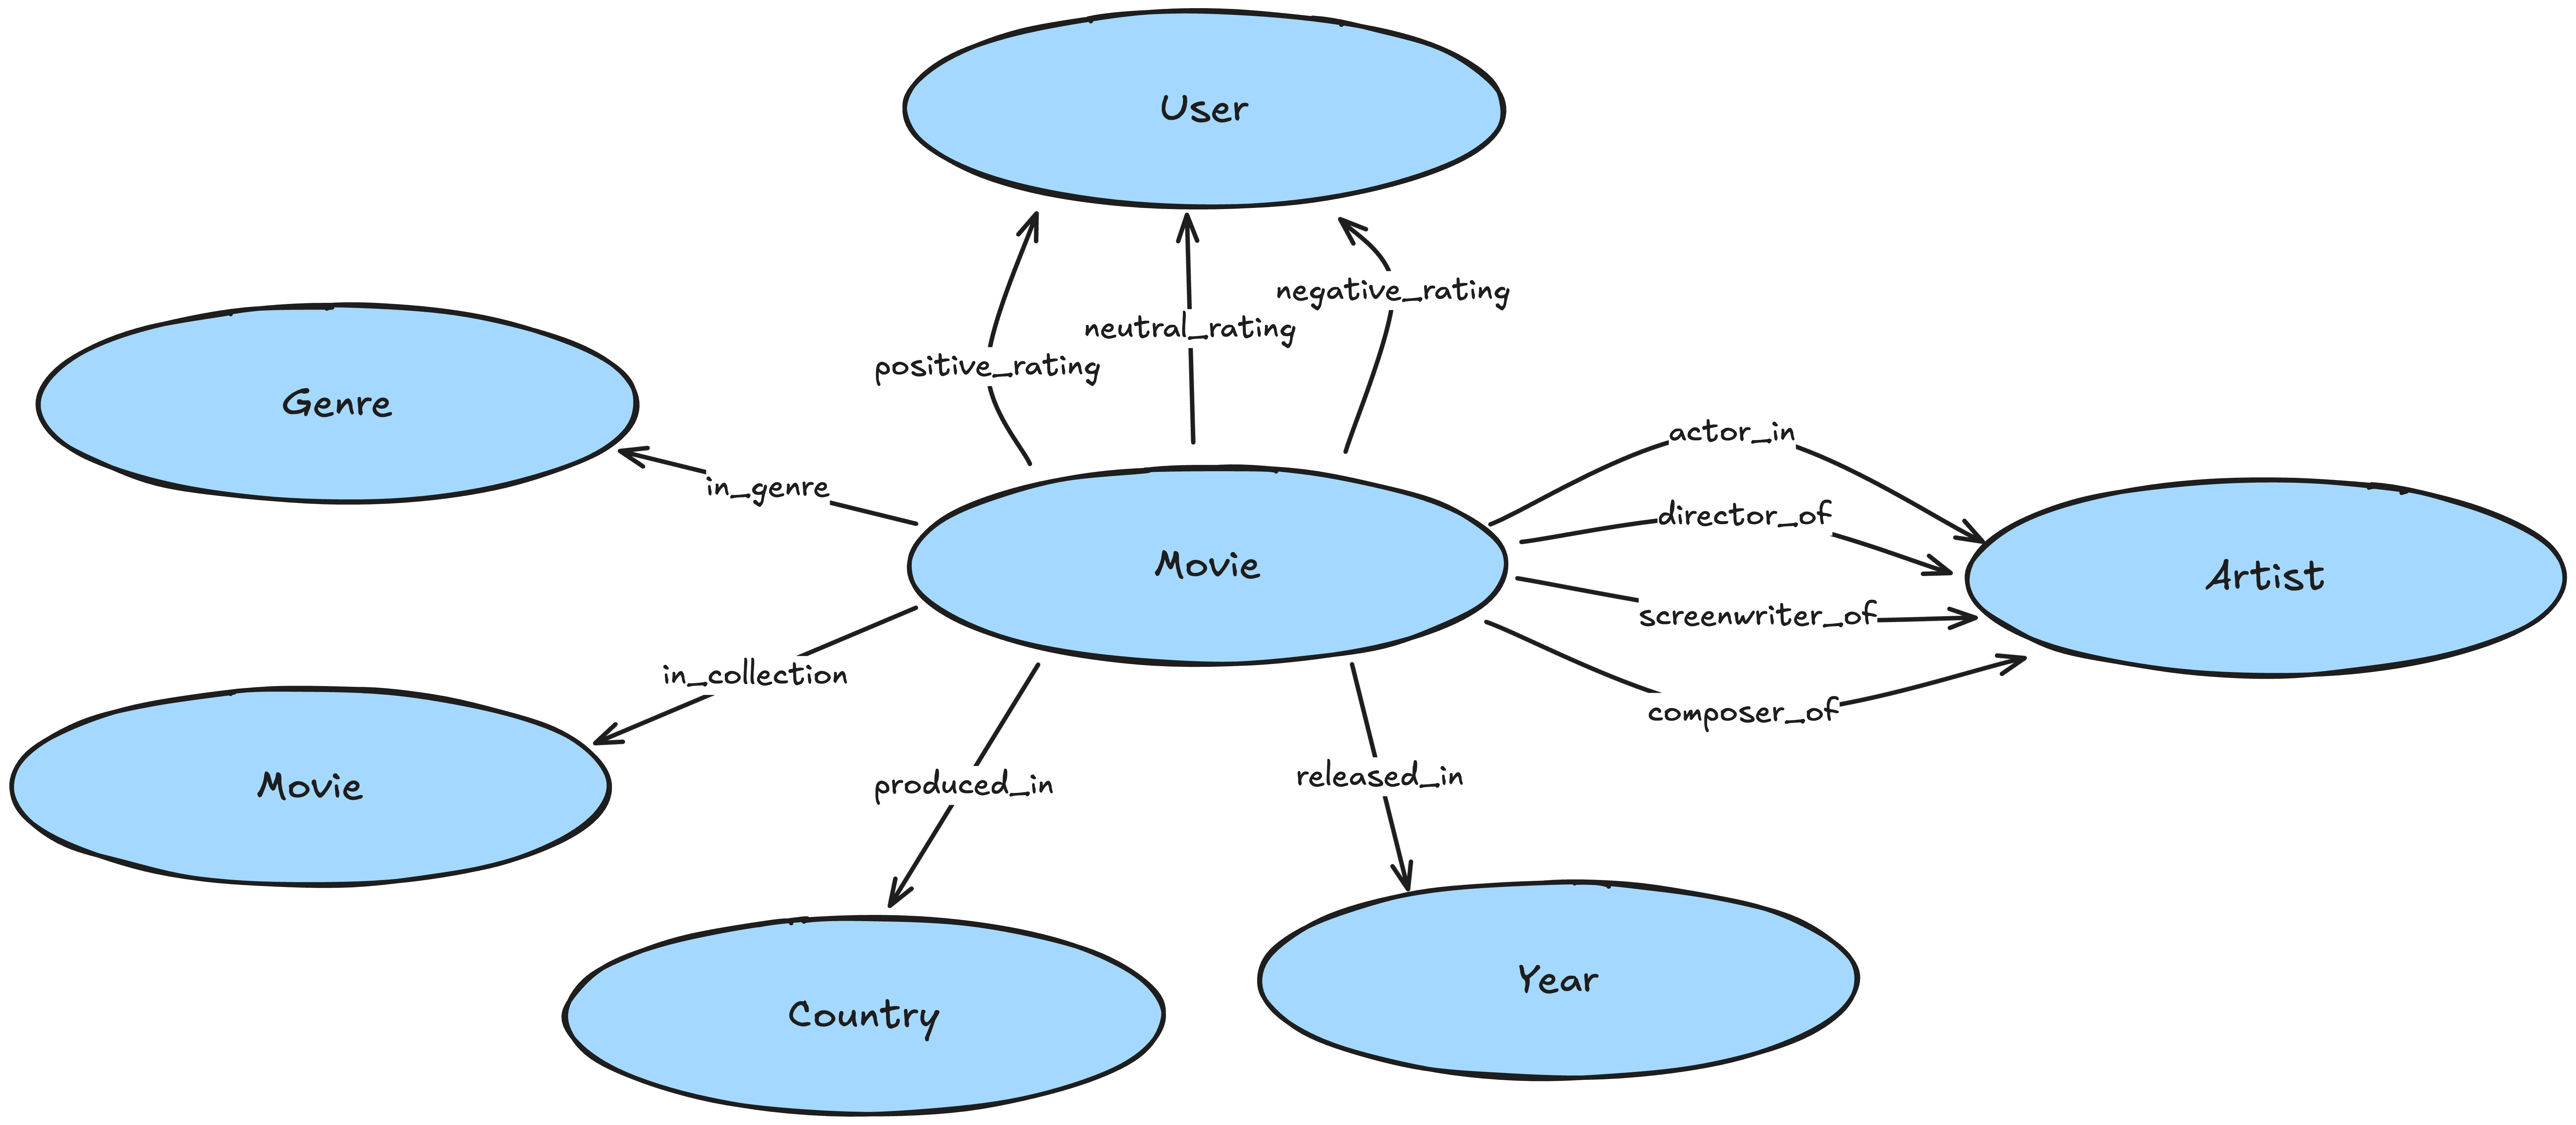

In [6]:
# generujemy dane dla modelu w formacie (head, relation, tail)
# na start możesz użyć małego podzbioru relacji, np. tylko 'positive_rating'
all_relation_types = [
    'positive_rating',
    'neutral_rating',
    'negative_rating',
    'genre',
    'production_country',
    'in_collection',
    'release_year',
    'actor_in',
    'director_of',
    'screenwriter_of',
    'composer_of'
]

basic_relation_types = [
    'positive_rating',
    'negative_rating'
]

def generate_triples(
    reviews: List[Review],
    movies: Dict[str, Movie],
    relation_types: List[str]
) -> List[Tuple[str, str, str]]:
    # przetłumacz dane o filmach i recenzjach do formy trójek (head, relation, tail)
    # np. (user_id, 'positive_rating', movie_id)
    # zwróć listę trzyelementowych krotek
    triples = []

    for review in reviews:
        # sprawdzam wszystkie możliwe relacje
        if 'positive_rating' in relation_types and review.rating >= 4.0:
            triples.append((review.user_id, 'positive_rating', review.movie_id))

        if 'neutral_rating' in relation_types and 2.0 < review.rating < 4.0:
            triples.append((review.user_id, 'neutral_rating', review.movie_id))
        
        if 'negative_rating' in relation_types and review.rating <= 2.0:
            triples.append((review.user_id, 'negative_rating', review.movie_id))

        if 'genre' in relation_types:
            for genre in movies[movie_id].genres:
                triples.append((genre, 'genre', review.movie_id))

        if 'production_country' in relation_types:
            for country in movies[movie_id].production_countries:
                triples.append((country, 'production_country', review.movie_id))

        if 'in_collection' in relation_types:
            triples.append((movies[movie_id].collection_name, 'in_collection', review.movie_id))

        if 'release_year' in relation_types:
            triples.append((movies[movie_id].release_year, 'release_year', review.movie_id))

        if 'actor_in' in relation_types:
            for actor in movies[movie_id].actors:
                triples.append((actor, 'actor_in', review.movie_id))

        if 'director_of' in relation_types:
            for director in movies[movie_id].directors:
                triples.append((director, 'director_of', review.movie_id))

        if 'screenwriter_of' in relation_types:
            for screenwriter in movies[movie_id].screenwriters:
                triples.append((screenwriter, 'screenwriter_of', review.movie_id))

        if 'composer_of' in relation_types:
            for composer in movies[movie_id].music_composers:
                triples.append((composer, 'composer_of', review.movie_id))

    return triples


triples = generate_triples(train_ratings, movies, basic_relation_types)
tf = TriplesFactory.from_labeled_triples(np.array(triples))

## Część 3. - trening modelu

In [7]:
def train_model(model: ERModel, tf: TriplesFactory, epochs: int):
    # tworzymy obiekt pomocniczy do reprezentacji zbioru danych
    training, testing, validation = tf.split([.8, .1, .1])

    # zasadnicza część treningu
    pipeline_result = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        model=model,
        epochs=epochs, 
    )
    
    return pipeline_result

# TransE to najszybszy, najprostszy, ale i najsłabszy model
# 100 epok to tylko przykładowa wartość, na podstawie loss plot ocenimy, czy wystarczy
pipeline_result = train_model(TransE, tf, 100)

using automatically assigned random_state=570206455
No random seed is specified. Setting to 1547919949.
No cuda devices were available. The model runs on CPU
c:\Users\micha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training epochs on cpu: 100%|██████████| 100/100 [01:25<00:00,  1.17epoch/s, loss=0.0953, prev_loss=0.0943]
Evaluating on cpu:   0%|          | 0.00/5.05k [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 5.05k/5.05k [00:04<00:00, 1.20ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 4.52s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

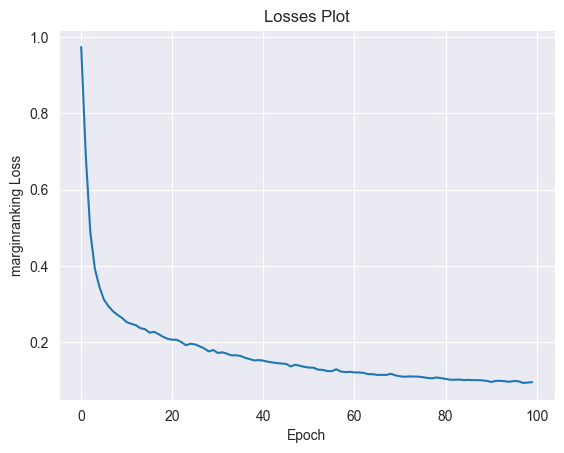

In [8]:
# wykres loss function
pipeline_result.plot_losses()

## Część 4. - rekomendacje

In [9]:
# funkcje pomocnicze
def print_movies(movie_ids: List[str], movies: Dict[str, Movie], print_missing=True):
    for m_id in movie_ids:
        if m_id in movies:
            print(movies[m_id].basic_info())
        elif print_missing:
            print(f'movie_id: {m_id}')


def describe_user(user_id: str, reviews: List[Review], movies: Dict[str, Movie]):
    positive_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating >= 4.0]
    negative_ratings = [x.movie_id for x in reviews if x.user_id == user_id and x.rating <= 2.0]
    neutral_ratings = [
        x.movie_id for x in reviews 
        if x.user_id == user_id and x.rating > 2.0 and x.rating < 4.0
    ]
    
    print(f'User_id: {user_id}')
    print('Positive ratings:')
    print_movies(positive_ratings, movies, print_missing=False)
    print('\nNeutral ratings:')
    print_movies(neutral_ratings, movies, print_missing=False)
    print('\nNegative ratings:')
    print_movies(negative_ratings, movies, print_missing=False)


def print_recommendation(user_id: str, recommendation: List[str], movies: Dict[str, Movie]):
    print(f'Recommendation for user {user_id} ({len(recommendation)} movies):')
    print_movies(recommendation, movies, print_missing=True)

In [10]:
def recommend(user_id: str, model: ERModel, triples_factory: TriplesFactory, k: int) -> List[str]:
    relation = 'positive_rating'
    prediction = predict_target(model, head=user_id, relation=relation, triples_factory=triples_factory)
    
    # wygeneruj rekomendację na podstawie predykcji
    sorted_prediction = prediction.df.sort_values(by='score', ascending=False)
    tail_labels = sorted_prediction['tail_label']
    recommendation = []

    for label in tail_labels:
        if len(recommendation) == k:
            break

        # upewniam się, że rekomendowany jest film
        if label[0] == 'm':
            recommendation.append(label)

    return recommendation

In [11]:
user_id = 'u_244'
describe_user(user_id, ratings, movies)
recommendation = recommend(user_id, pipeline_result.model, tf, 20)

User_id: u_244
Positive ratings:
{'movie_id': 'm_58559', 'title': 'Confession of a Child of the Century', 'genres': ['Drama'], 'production_countries': ['FR', 'DE', 'GB']}
{'movie_id': 'm_2011', 'title': 'Persepolis', 'genres': ['Animation', 'Drama'], 'production_countries': ['FR', 'US']}
{'movie_id': 'm_318', 'title': 'The Million Dollar Hotel', 'genres': ['Drama', 'Thriller'], 'production_countries': ['US', 'DE']}
{'movie_id': 'm_54272', 'title': '座頭市関所破り', 'genres': ['Adventure', 'Action', 'Drama'], 'production_countries': ['JP']}
{'movie_id': 'm_1374', 'title': 'Rocky IV', 'genres': ['Drama'], 'production_countries': ['US']}
{'movie_id': 'm_4993', 'title': '5 Card Stud', 'genres': ['Action', 'Western', 'Thriller'], 'production_countries': ['US']}
{'movie_id': 'm_2005', 'title': 'Sister Act', 'genres': ['Music', 'Comedy'], 'production_countries': ['US']}
{'movie_id': 'm_527', 'title': 'Once Were Warriors', 'genres': ['Drama'], 'production_countries': ['NZ']}
{'movie_id': 'm_260', 'ti

In [12]:
print_recommendation(user_id, recommendation, movies)

Recommendation for user u_244 (20 movies):
{'movie_id': 'm_4993', 'title': '5 Card Stud', 'genres': ['Action', 'Western', 'Thriller'], 'production_countries': ['US']}
movie_id: m_4306
movie_id: m_1210
movie_id: m_6377
movie_id: m_2571
movie_id: m_79132
movie_id: m_5952
movie_id: m_6539
{'movie_id': 'm_68954', 'title': 'Longitude', 'genres': ['TV Movie', 'Drama', 'History'], 'production_countries': ['GB', 'US']}
movie_id: m_6365
movie_id: m_7153
{'movie_id': 'm_2000', 'title': 'Aguirre, der Zorn Gottes', 'genres': ['Adventure', 'Drama', 'History'], 'production_countries': ['DE', 'PE']}
movie_id: m_1214
movie_id: m_3793
{'movie_id': 'm_54503', 'title': 'Shuang ma lian huan', 'genres': ['Action', 'Foreign'], 'production_countries': ['HK', 'TW']}
{'movie_id': 'm_260', 'title': 'The 39 Steps', 'genres': ['Action', 'Thriller', 'Mystery'], 'production_countries': ['GB']}
movie_id: m_1036
movie_id: m_5349
movie_id: m_589
{'movie_id': 'm_2005', 'title': 'Sister Act', 'genres': ['Music', 'Comedy

In [13]:
# użytkownik z bardzo dużą historią
user_id = 'u_547'
describe_user(user_id, ratings, movies)
recommendation = recommend(user_id, pipeline_result.model, tf, 20)

User_id: u_547
Positive ratings:
{'movie_id': 'm_2018', 'title': 'The Wedding Planner', 'genres': ['Comedy'], 'production_countries': ['US']}
{'movie_id': 'm_1964', 'title': 'Ein Freund von mir', 'genres': ['Drama'], 'production_countries': ['DE']}
{'movie_id': 'm_581', 'title': 'Dances with Wolves', 'genres': ['Adventure', 'Drama', 'Western'], 'production_countries': ['GB', 'US']}
{'movie_id': 'm_1254', 'title': "Je vais bien, ne t'en fais pas", 'genres': ['Drama'], 'production_countries': ['FR']}
{'movie_id': 'm_300', 'title': 'La science des rêves', 'genres': ['Comedy', 'Drama', 'Fantasy'], 'production_countries': ['FR', 'IT']}
{'movie_id': 'm_1946', 'title': 'eXistenZ', 'genres': ['Action', 'Thriller', 'Science Fiction', 'Horror'], 'production_countries': ['CA', 'FR', 'GB']}
{'movie_id': 'm_25', 'title': 'Jarhead', 'genres': ['Drama', 'War'], 'production_countries': ['DE', 'US']}
{'movie_id': 'm_2455', 'title': 'Vivement dimanche!', 'genres': ['Drama', 'Comedy', 'Crime'], 'producti

In [14]:
print_recommendation(user_id, recommendation, movies)

Recommendation for user u_547 (20 movies):
movie_id: m_2858
movie_id: m_1198
{'movie_id': 'm_899', 'title': 'Broken Blossoms', 'genres': ['Drama', 'Romance'], 'production_countries': ['US']}
{'movie_id': 'm_1394', 'title': 'Nostalghia', 'genres': ['Drama', 'Romance'], 'production_countries': ['SU', 'IT']}
movie_id: m_1193
{'movie_id': 'm_608', 'title': 'Men in Black II', 'genres': ['Action', 'Adventure', 'Comedy', 'Science Fiction'], 'production_countries': ['US']}
movie_id: m_7139
{'movie_id': 'm_1247', 'title': 'The Good Shepherd', 'genres': ['Drama', 'Thriller', 'History'], 'production_countries': ['US']}
movie_id: m_2245
movie_id: m_1208
movie_id: m_2997
movie_id: m_1258
movie_id: m_50
{'movie_id': 'm_2395', 'title': 'Astérix aux Jeux Olympiques', 'genres': ['Fantasy', 'Adventure', 'Comedy', 'Family'], 'production_countries': ['BE', 'FR', 'DE', 'IT', 'ES']}
movie_id: m_3545
movie_id: m_1288
movie_id: m_1221
{'movie_id': 'm_1284', 'title': 'Torrente 2: Misión en Marbella', 'genres':

## Część 5. - metryki

In [15]:
# hitRatio@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# dla każdej oceny generujemy rekomendację długości k dla użytkownika
# i sprawdzamy, czy oceniony film znalazł się w rekomendacji
# zwracamy stosunek liczby trafień do liczby wszystkich prób
# wersja nieco bardziej zaawansowana - zamiast rekomendacji wyciągamy z modelu predykcję konkretnej 
# relacji i liczymy skuteczność w przewidywaniu, czy ocena była pozytywna, negatywna czy neutralna
def hit_ratio(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int) -> float:
    hits = 0
    filtered_ratings = list(filter(lambda r: r.rating >= 4.0, test_ratings))

    for review in filtered_ratings:
        recommendation = recommend(review.user_id, model, tf, k)

        if review.movie_id in recommendation:
            hits += 1

    return hits / len(filtered_ratings)


hit_ratio(test_ratings, pipeline_result.model, tf, 50)

0.14013452914798205

In [16]:
# avgPosition@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# dla każdej oceny generujemy rekomendację długości k dla użytkownika
# i sprawdzamy, czy oceniony film znalazł się w rekomendacji
# jeśli tak, zapisujemy pozycję, na której zarekomendowano film
# zwracamy średnią pozycję, na której występowały filmy
def avg_position(test_ratings: List[Review], model: ERModel, tf: TriplesFactory, k: int) -> float:
    positions_sum = 0
    no_recommendations = 0
    filtered_ratings = list(filter(lambda r: r.rating >= 4.0, test_ratings))

    for review in filtered_ratings:
        recommendation = recommend(review.user_id, model, tf, k)

        if review.movie_id in recommendation:
            no_recommendations += 1
            positions_sum += recommendation.index(review.movie_id)

    return positions_sum / no_recommendations


avg_position(test_ratings, pipeline_result.model, tf, 50)

23.1056

## Część 6. - porównanie modeli

Wytrenowaliśmy podstawowy model, umiemy wygenerować rekomendacje i ocenić jakość modelu. Teraz przeanalizujemy, jakie zmiany mogą pozytywnie wpłynąć na jakość rekomendacji.

Porównaj bazowy model (np. `TransH` wytrenowany tylko na relacjach *positive_rating* i *negative_rating*) z dwoma innymi podejściami. Wybierz dwie spośród poniższych modyfikacji lub zaproponuj własną:
1. Zmiana modelu - zamiast `TransH` możesz użyć np. `TransR` albo `RESCAL`
2. Dodanie większej liczby typów relacji - możesz dodać oceny neutralne, metadane filmu, informacje o obsadzie. Nawet jeśli jakaś relacja nie jest wykorzystywana w procesie rekomendacji, może poprawić jakość wytrenowanego modelu. Zwróć uwagę, żeby jako rekomendację zwracać wyłącznie identyfikatory filmów, nie innych wierzchołków.
3. Zmiana sposobu rekomendacji - obecny tryb opiera się na przewidywaniu relacji `positive_rating`. Możesz poprawić ten proces przez np. odsiewanie tych kandydatów, którzy występują także w predykcji relacji `negative_rating` czy filtrowanie kandydatów po metadanych (np. gatunku).

Porównanie trzech modeli oprzyj na dwóch zdefiniowanych w części 5. metrykach dla wybranej wartości `k`.

In [17]:
# TransH traktuję tutaj jako bazowy model
# podaję 150 epok ze względu na wolniejsze zbieganie się tego modelu
base_model_pipeline_result = train_model(TransH, tf, 150)
base_model = base_model_pipeline_result.model

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [37974, 5048, 5049]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
c:\Users\micha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training epochs on cpu: 100%|██████████| 150/150 [03:12<00:00,  1.28s/epoch, loss=0.377, prev_loss=0.377]
Evaluating on cpu:   0%|          | 0.00/5.05k [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

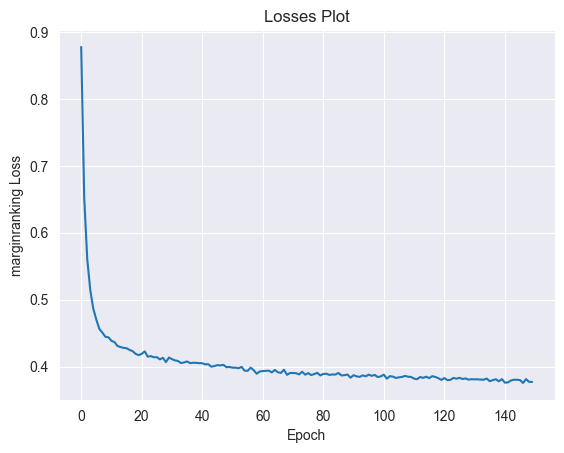

In [18]:
# wykres loss function
base_model_pipeline_result.plot_losses()

In [19]:
# wybrana wartość k
k = 50

# wartości metryk dla bazowego modelu
ratio = hit_ratio(test_ratings, base_model, tf, k)
position = avg_position(test_ratings, base_model, tf, k)
print("Hit ratio:", ratio)
print("Average position:", position)

Hit ratio: 0.13542600896860987
Average position: 23.5


In [20]:
# zmiana modelu na TransR; 200 epok dla bardziej złożonego modelu
new_model1_pipeline_result = train_model(TransR, tf, 200)
new_model1 = new_model1_pipeline_result.model

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [37974, 5048, 5049]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
c:\Users\micha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training epochs on cpu: 100%|██████████| 200/200 [05:42<00:00,  1.71s/epoch, loss=0.337, prev_loss=0.338]
Evaluating on cpu:   0%|          | 0.00/5.05k [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

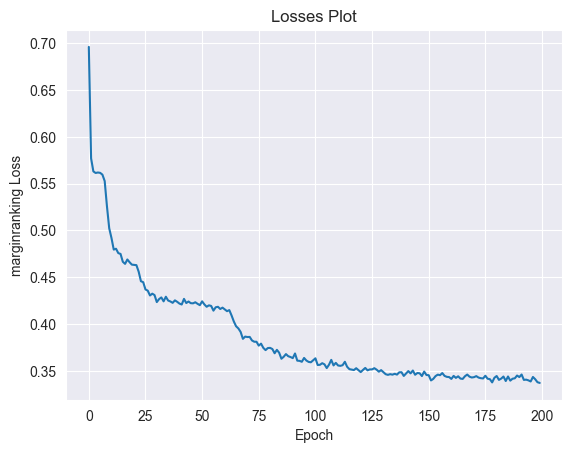

In [21]:
# wykres loss function
new_model1_pipeline_result.plot_losses()

In [22]:
# wartości metryk dla nowego modelu
ratio = hit_ratio(test_ratings, new_model1, tf, k)
position = avg_position(test_ratings, new_model1, tf, k)
print("Hit ratio:", ratio)
print("Average position:", position)

Hit ratio: 0.13654708520179373
Average position: 23.95402298850575


In [23]:
# spróbujmy z dodaniem większej liczby typów relacji
extended_relation_types = [
    'positive_rating',
    'negative_rating',
    'genre',
    'in_collection',
    'actor_in',
    'director_of',
]

new_triples = generate_triples(train_ratings, movies, extended_relation_types)
new_tf = TriplesFactory.from_labeled_triples(np.array(new_triples))

In [28]:
# nadal trenuję model TransR, ze względu na dodanie nowych typów relacji przez 300 epok
new_model2_pipeline_result = train_model(TransR, new_tf, 300)
new_model2 = new_model2_pipeline_result.model

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [57958, 7548, 7549]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
c:\Users\micha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Training epochs on cpu: 100%|██████████| 300/300 [17:17<00:00,  3.46s/epoch, loss=0.371, prev_loss=0.371]
Evaluating on cpu:   0%|          | 0.00/7.55k [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

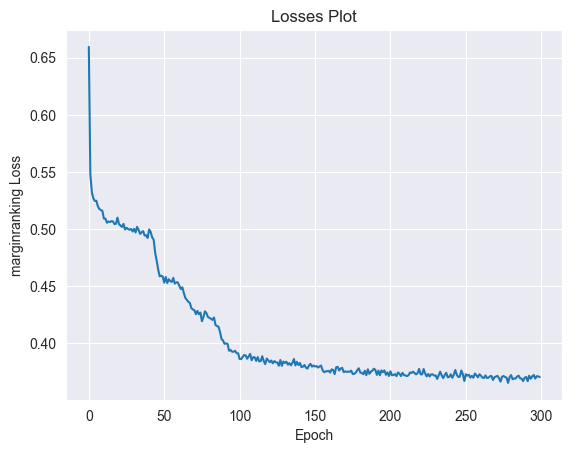

In [29]:
# wykres loss function
new_model2_pipeline_result.plot_losses()

In [30]:
# wartości metryk dla nowego modelu
ratio = hit_ratio(test_ratings, new_model2, new_tf, k)
position = avg_position(test_ratings, new_model2, new_tf, k)
print("Hit ratio:", ratio)
print("Average position:", position)

Hit ratio: 0.12757847533632288
Average position: 23.924428822495607
